In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('F:/Linux')
sys.path.append("C:/Users/qq651/OneDrive/Codes/A2project/")
import illustris_python as il
import matplotlib.pyplot as plt
from plotTools.plot import *


def loadConc(path, snapshots):
    res = {}
    for snap in snapshots:
        data = np.fromfile(path + '%d.conc' % snap, 'd')
        res[snap] = data

    return res

def loadProf(path, snapshots):
    res = {}
    for snap in snapshots:
        data = np.fromfile(path + '%d.prof' % snap, dtype='f')
        halos = int(len(data) / 30)
        res[snap] = data.reshape(halos, 2, 15)
    return res

def Y_rawdata(data, snapnum):
    plotdata = [[], [], []]
    for snap in snapnum:
        d0, d1, d2 = ErrorBarMedian(data[snap])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1, :], Err

def findGid(simu, snap, ids):
    res = []
    GID = il.func.loadSubhalos(simu, snap, 'SubhaloGrNr')
    for haloID in ids:
        try:
            prog = LoadMergHist(simu, haloID)[0]
            subID = prog[snap]
        except:
            continue

        res.append(GID[subID])
    return np.unique(res)

def ConcData(simu, snap, diskID, ids, data):
    diskGID = findGid(simu, snap, diskID)
    gid = findGid(simu, snap, ids)
    
    ind = []
    for haloID in gid:
        ind.append(np.where(diskGID == haloID)[0][0])
    
    return data[ind]

def fitConc(data, redshift):
    a = 1 / (1 + redshift)

    H0 = 0.1
    G = 4.3e4
    Omega = 0.3089
    OmegaLambda = 0.6911

    hh = 1 #(Omega*pow((1.0+redshift),3.0) + (1.0-Omega-OmegaLambda)*pow((1.0+redshift),2.0) + OmegaLambda)
    rhofactor = 3.0 * H0 * H0 / 8.0 / np.pi / G # / a ** 2
    diffmin = 1e20
    cmin = 1.0
    x = data[0]
    y = data[1] / a / 0.7 ** 2
    plt.plot(x, y, ls='-.')
    for c in [8, 20]:
        deltac = 200.0 / 3.0 * pow(c, 3.0) / (np.log(1.0 + c) - c / (1.0 + c))

        rho = rhofactor * deltac / ((c * x) * pow((1.0 + c * x), 2.0))
        diff = abs((np.log(rho) - np.log(y)).sum())
        plt.plot(x, rho, label='%d' % (c))
        if diff < diffmin:
            diffmin = diff
            cmin = c

    plt.loglog()
    plt.legend()
    return cmin


def getConcTest(simu, data, redshift):
    a = 1 / (1 + redshift)
    H0 = 0.1
    if simu == 'tng' or simu == 'TNG':
        Omega = 0.3089
        OmegaLambda = 0.6911
    else:
        Omega = 0.2726
        OmegaLambda = 0.7274

    Omega = 0.3089
    OmegaLambda = 0.6911
    G = 4.3e4

    hh = (Omega * pow((1.0 + redshift), 3.0) + (1.0 - Omega - OmegaLambda) * pow((1.0 + redshift), 2.0) + OmegaLambda)
    rhoCrit = 2.78e-8 * H0 ** 2 * hh
    rhofactor = 3.0 * H0 * H0 / 8.0 / np.pi / G * hh
    
    diffmin = 1e20
    cmin = 1.0
    last = 14
    for i in range(15):
        if data[1][i] < 1e-9:
            last = i-1
            break
    x = data[0][1:last] * a
    y = data[1][1:last] / a ** 3 * hh
    print(x)
    plt.plot(x, y, ls='-.',marker='o', label='%d'%redshift)

    for c in np.arange(3, 12, 1):
        deltac = 200.0 / 3.0 * pow(c, 3.0) / (np.log(1.0 + c) - c / (1.0 + c))

        rho = rhofactor * deltac / ((c*x) * pow((1.0 + c*x), 2.0))

        diff = (((rho-y)/y)**2).sum()
        
        
        plt.plot(x, rho, label='%d %.2f' % (c, redshift))

        
        if diff < diffmin:
            diffmin = diff
            cmin = c

    plt.loglog()
    # plt.legend()
    return cmin

def fitc(simu, data, redshift):
    a = 1 / (1 + redshift)
    H0 = 0.1
    if simu == 'tng' or simu == 'TNG':
        Omega = 0.3089
        OmegaLambda = 0.6911
    else:
        Omega = 0.2726
        OmegaLambda = 0.7274

    Omega = 0.3089
    OmegaLambda = 0.6911
    G = 4.3e4

    hh = (Omega * pow((1.0 + redshift), 3.0) + (1.0 - Omega - OmegaLambda) * pow((1.0 + redshift), 2.0) + OmegaLambda)
    #rhoCrit = 2.78e-8 * H0 ** 2 * hh
    rhofactor = 3.0 * H0 * H0 / 8.0 / np.pi / G * hh
    
    diffmin = 1e20
    cmin = 1.0
    last = 14
    for i in range(15):
        if data[1][i] < 1e-9:
            last = i-1
            break
    x = data[0][1:last] * a
    y = data[1][1:last] / a ** 3 * hh
    for c in np.arange(3, 18.5, 0.1):
        deltac = 200.0 / 3.0 * pow(c, 3.0) / (np.log(1.0 + c) - c / (1.0 + c))
        rho = rhofactor * deltac / ((c * x) * pow((1.0 + c * x), 2.0))
        diff = (((rho-y)/y)**2).sum()
        if diff < diffmin:
            diffmin = diff
            cmin = c

    return cmin * a

In [2]:
rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68]
tng_snap = [99, 84, 67, 59, 50, 40, 33]

tng_prof = loadProf('F:/Linux/localRUN/concRes/tng/', tng_snap)
il1_prof = loadProf('F:/Linux/localRUN/concRes/il1/', il1_snap)

il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy', allow_pickle=1)
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy', allow_pickle=1)

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy', allow_pickle=1)
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy', allow_pickle=1)
tng_unbarID = []
for haloID in tng_diskID:
    if haloID not in tng_barID:
        tng_unbarID.append(haloID)

il1_unbarID = []
for haloID in il1_diskID:
    if haloID not in il1_barID:
        il1_unbarID.append(haloID)

<ErrorbarContainer object of 3 artists>

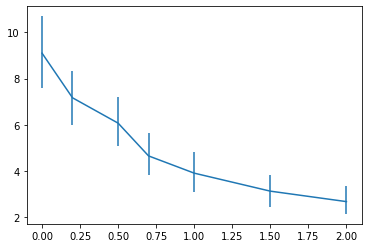

In [3]:
il1_conc = {}
for i in range(7):
    redshift = rs[i]
    snap = il1_snap[i]
    tmp = []
    for j in range(len(il1_prof[snap])):
        tmp.append(fitc('il1', il1_prof[snap][j], redshift))
    il1_conc[snap] = np.array(tmp)

y, err = Y_rawdata(il1_conc, il1_snap)
plt.errorbar(rs, y, err)


<ErrorbarContainer object of 3 artists>

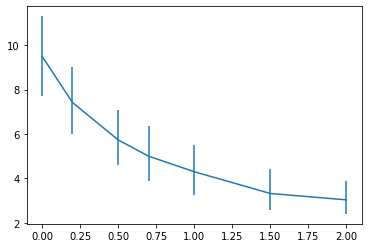

In [4]:
tng_conc = {}
for i in range(7):
    redshift = rs[i]
    snap = tng_snap[i]
    tmp = []
    for j in range(len(tng_prof[snap])):
        tmp.append(fitc('tng', tng_prof[snap][j], redshift))
    tng_conc[snap] = np.array(tmp)

y, err = Y_rawdata(tng_conc, tng_snap)
plt.errorbar(rs, y, err)

In [5]:
tng_c = np.load('f:/Linux/localRUN/concRes/tngConc.npy', allow_pickle=1).item()
il1_c = np.load('f:/Linux/localRUN/concRes/il1Conc.npy', allow_pickle=1).item()

In [6]:
tng_bar_c = {}
tng_unbar_c = {}

for snap in tng_snap:
    tng_bar_c[snap]= (ConcData('TNG', snap, tng_diskID, tng_barID, tng_c[snap]))
    tng_unbar_c[snap] = (ConcData('TNG', snap, tng_diskID, tng_unbarID, tng_c[snap]))
    

il1_bar_c = {}
il1_unbar_c = {}

for snap in il1_snap:
    il1_bar_c[snap]= (ConcData('il1', snap, il1_diskID, il1_barID, il1_c[snap]))
    il1_unbar_c[snap] = (ConcData('il1', snap, il1_diskID, il1_unbarID, il1_c[snap]))

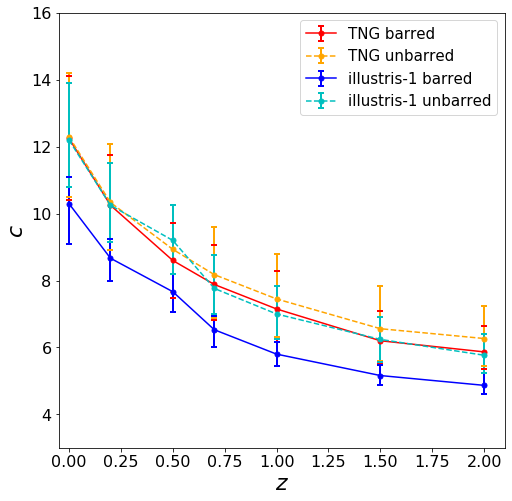

In [11]:
plt.figure(figsize=(8,8))
bar_Y, bar_err = Y_rawdata(tng_bar_c, tng_snap)
un_Y, un_err = Y_rawdata(tng_unbar_c, tng_snap)

il1_bar_Y, il1_bar_err = Y_rawdata(il1_bar_c, il1_snap)
il1_un_Y, il1_un_err = Y_rawdata(il1_unbar_c, il1_snap)


plt.errorbar(rs, bar_Y, bar_err, elinewidth=2, label='TNG barred', capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-')
plt.errorbar(rs, un_Y, un_err, elinewidth=2, label='TNG unbarred', capthick=2, capsize=3, color='orange', fmt='o', ms=5, ls='--')

plt.errorbar(rs, il1_bar_Y, il1_bar_err, elinewidth=2, label='illustris-1 barred', capthick=2, capsize=3, color='blue', fmt='o',ms=5, ls='-')
plt.errorbar(rs, il1_un_Y, il1_un_err, elinewidth=2, label='illustris-1 unbarred', capthick=2, capsize=3, color='c', fmt='o', ms=5, ls='--')

plt.xlim(-0.05, 2.1)
plt.ylim(3,16)
plt.xlabel('$z$', fontsize=22)
plt.ylabel('$c$', fontsize=22)
plt.legend(fontsize=15)
plt.tick_params(labelsize=16)
plt.savefig('f:/Linux/local_result/conc/conc_sepa_V2.pdf')

In [8]:
tng_sPtcl = il.func.loadSubhalos('TNG', 99, 'SubhaloLenType')[:, 4]
il1_sPtcl = il.func.loadSubhalos('il1', 135, 'SubhaloLenType')[:, 4]

In [9]:
mask = tng_sPtcl[tng_diskID] >= 100000
tng_bigID = tng_diskID[mask]
tng_smlID = tng_diskID[~mask]

mask = il1_sPtcl[il1_diskID] >= 100000
il1_bigID = il1_diskID[mask]
il1_smlID = il1_diskID[~mask]

tng_big = {}
tng_sml = {}
for snap in tng_snap:
    tng_big[snap]= (ConcData('TNG', snap, tng_diskID, tng_bigID, tng_c[snap]))
    tng_sml[snap]= (ConcData('TNG', snap, tng_diskID, tng_smlID, tng_c[snap]))
    
il1_big = {}
il1_sml = {}
for snap in il1_snap:
    il1_big[snap]= (ConcData('il1', snap, il1_diskID, il1_bigID, il1_c[snap]))
    il1_sml[snap]= (ConcData('il1', snap, il1_diskID, il1_smlID, il1_c[snap]))
    

In [10]:
tng_sMass = il.func.loadSubhalos('TNG', 99, 'SubhaloMassType')[:, 4] / 0.6774
tng_sMass = np.log10(tng_sMass * 10 ** 10)
il1_sMass = il.func.loadSubhalos('il1', 135, 'SubhaloMassType')[:, 4] / 0.704
il1_sMass = np.log10(il1_sMass * 10 ** 10)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [47]:
t1 = tng_sMass[tng_smlID].min()
t2 = tng_sMass[tng_bigID].min()
t3 = tng_sMass[tng_bigID].max()

In [48]:
t1, t2, t3

(10.572428935367393, 10.969425452506156, 12.117565608289441)

In [49]:
i1 = il1_sMass[il1_smlID].min()
i2 = il1_sMass[il1_bigID].min()
i3 = il1_sMass[il1_bigID].max()

In [50]:
i1, i2, i3

(10.528295375114967, 10.908950609269636, 11.821234943222855)

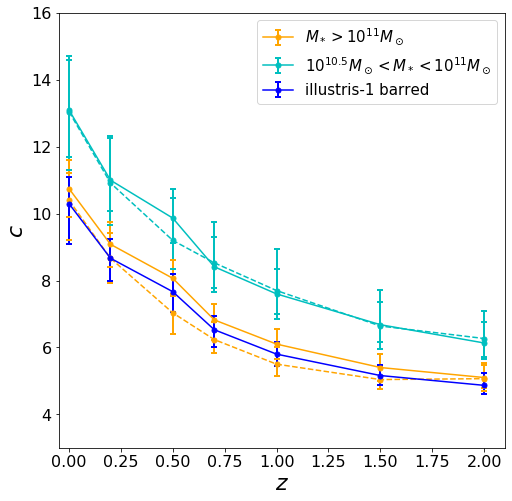

In [12]:
plt.figure(figsize=(8,8))
big_Y, big_err = Y_rawdata(tng_big, tng_snap)
sml_Y, sml_err = Y_rawdata(tng_sml, tng_snap)
il1_big_Y, il1_big_err = Y_rawdata(il1_big, il1_snap)
il1_sml_Y, il1_sml_err = Y_rawdata(il1_sml, il1_snap)


plt.errorbar(rs, big_Y, big_err, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='--')
plt.errorbar(rs, sml_Y, sml_err, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o', ms=5, ls='--')


plt.errorbar(rs, il1_big_Y, il1_big_err, elinewidth=2, label=r'$M_* > 10^{11}M_\odot$', capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-')
plt.errorbar(rs, il1_sml_Y, il1_sml_err, elinewidth=2, label=r'$10^{10.5}M_\odot < M_* < 10^{11}M_\odot$', capthick=2, capsize=3, color='c', fmt='o', ms=5, ls='-')

plt.errorbar(rs, il1_bar_Y, il1_bar_err, elinewidth=2, label='illustris-1 barred', capthick=2, capsize=3, color='blue', fmt='o',ms=5, ls='-')


plt.xlim(-0.05, 2.1)
plt.ylim(3,16)
plt.xlabel('$z$', fontsize=22)
plt.ylabel('$c$', fontsize=22)
plt.legend(fontsize=15)
plt.tick_params(labelsize=16)
plt.savefig('f:/Linux/local_result/conc/conc_BS.pdf')